<a href="https://colab.research.google.com/github/annvorosh/GB/blob/Alg_AD/Alg_AD_L7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## УРОК 7. Классификация с помощью kNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.


In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

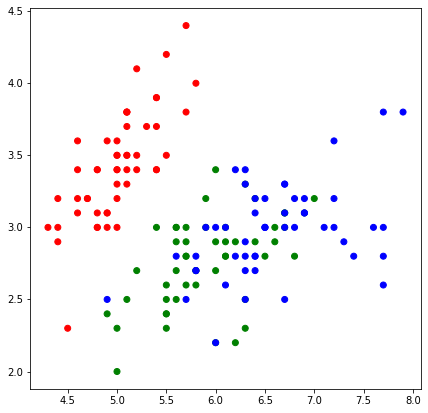

In [ ]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [ ]:
def e_metrics(x1, x2):
    '''Используем евклидову метрику'''
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])

    return np.sqrt(distance)

In [ ]:
def knn(x_train, y_train, x_test, k, weighed_method = 0):
    '''алгоритм поиска k ближайших соседей.'''
    '''weighed_method:
                0 - не взвешено
                1 - q**i
                2 - 1/i
                3 - 1/(i+a)**b
                4 - (k+1 - i)/k
                5 - q**d'''
    answers = []

    for x in x_test:
        test_distances = []

        for i in range(len(x_train)):

            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])

            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))

        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}


        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        i = 1
        for d in sorted(test_distances)[0:k]:
            if weighed_method == 0:
                classes[d[1]] += 1
            if weighed_method == 1:
                classes[d[1]] += 1/i
            if weighed_method == 2:
                q = 0.5
                classes[d[1]] += q**i
            if weighed_method == 3:
                a = 3
                b = 2
                classes[d[1]] += 1/(i+a)**b
            if weighed_method == 4:
                a = 3
                classes[d[1]] += (k + 1 - i)/k
            if weighed_method == 5:
                q = 0.75
                classes[d[1]] += q**d[0]
            i += 1
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [ ]:
def accuracy(pred, y):
    '''вычисление точности'''
    return (sum(pred == y) / len(y))

In [ ]:
def get_graph(X_train, y_train, k, w):
    '''график распределения классов'''
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, w)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Точность алгоритма при k = 15 и w = 0: 0.833


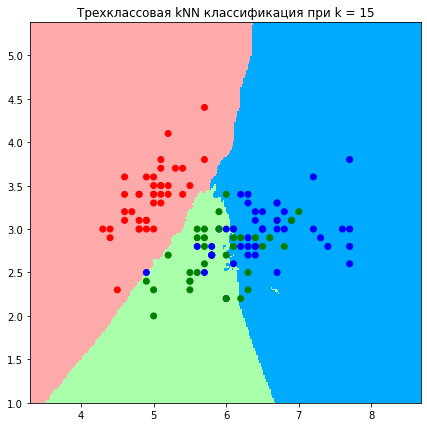

Точность алгоритма при k = 15 и w = 1: 0.767


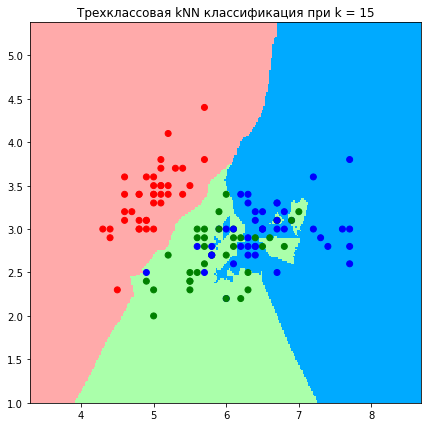

Точность алгоритма при k = 15 и w = 2: 0.667


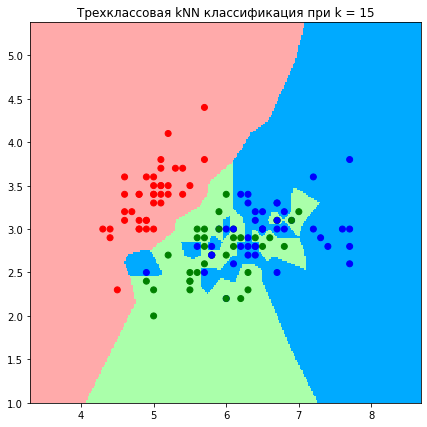

Точность алгоритма при k = 15 и w = 3: 0.767


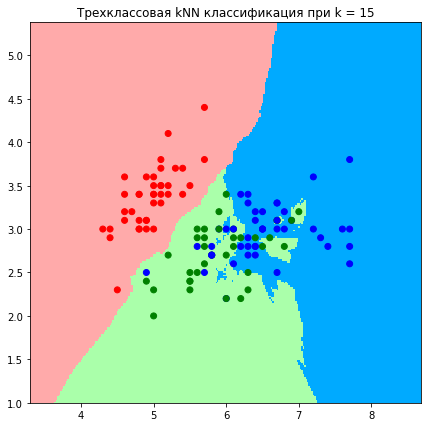

Точность алгоритма при k = 15 и w = 4: 0.867


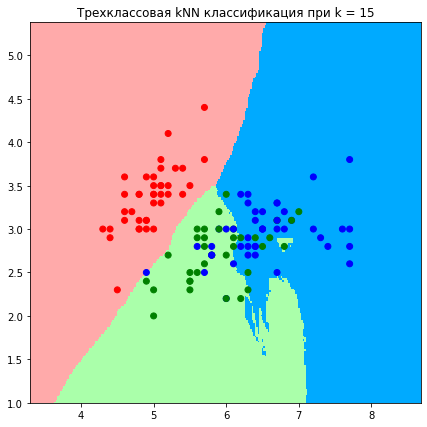

Точность алгоритма при k = 15 и w = 5: 0.833


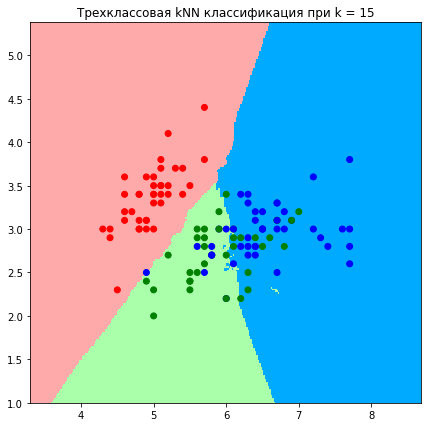

In [ ]:
for w in range(6):
    k = 15
    y_pred = knn(X_train, y_train, X_test, k, weighed_method = w)
    print(f'Точность алгоритма при k = {k} и w = {w}: {accuracy(y_pred, y_test):.3f}')
    get_graph(X_train, y_train, k, w)

2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.

In [ ]:
from sklearn.datasets import make_blobs
import random

In [ ]:
X, y = make_blobs(n_samples=300, random_state=1)

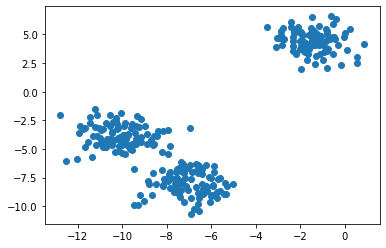

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}

    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]

    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)

        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()

        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)

        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False

        # если все смещения меньше минимального, останавливаем алгоритм
        if optimal:
            break

    return old_centroids, classes

In [ ]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']

    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')

    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])

    plt.show()

In [ ]:
def e_metrics_clusters(clusters, centroids):
    '''Используем евклидову метрику'''
    distance = 0
    for i in range(len(centroids)):
        distance += np.square(clusters[i] - centroids[i])

    return np.sqrt(distance)

In [ ]:

def n_clusters_find(X, max_iterations, min_distance):
    metrics = []
    for k in range(10):
        centroids, clusters = kmeans(X, k+1, max_iterations, min_distance)
        metrics.append(e_metrics_clusters(clusters[k], centroids[k]))
    plt.figure(figsize=(15, 10))
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Quality of clustering')
    plt.plot(metrics)
    plt.show()

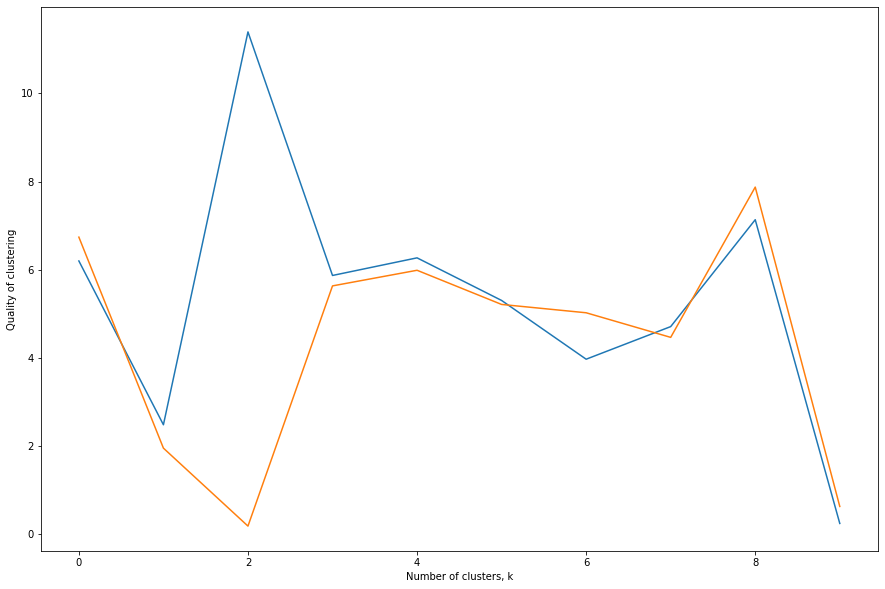

In [ ]:
n_clusters_find(X, max_iterations = 10, min_distance = 1e-4)